# Introduction

### Problem Statement

Given a sequence of peptide amino acids, we want to predict the instrinsic peptide detectability in mass spectrometry experiments.

### Problem Background

A proteome is the complete set of proteins that can be expressed by an organism or a part of an organism, such as a genome or a cell. Proteomics can help identify biomarkers by examining proteins in bodily fluids, such as the presence of human epidermal growth factor receptor 2 which predicts the response to trastuzumab (a targeted anticancer drug) in cases of breast cancer. Other applications aside from guiding personalized cancer treatment include drug discovery, microbe identification, and newborn screening at the point-of-care [1][7].

Advances in high-throughput mass spectrometry (MS) have boosted protein detection and quantification efforts. MS-based methods detect proteins and peptide molecules by breaking intact molecules and measuring their weight-related ions. First, samples are handled (collected, processed, and tracked) and prepared (pretreatments, protein extraction, digestion, purification, fractionation). Then, data is acquired and analyzed through databases, spectral libraries, and peptide sequencing until the protein is identified. [7]

Peptide detectability is the probability that a peptide is detected in an MS experiment, which is helpful in protein inference and label-free quantification. However, there are currently obstacles to measuring peptides in a sample. [5] The ability for mass spectrometers to detect a specific peptide is affected by many external factors during sample handling and preparation, as well as bias introduced by the specific MS instrument. [3] Further, machine learning models that rely on standard protein mixture data for training detectability could suffer from the unequal distribution of peptides in non-standard samples, meaning the intrinsic detectability of peptides are not being learned. This means that model performance is affected by the relative abundance of proteins in samples. [5]

### Problem Value

Being able to learn the intrinsic detectability of a peptide would lead to more accurate calculations in the process of protein identification, which has numerous benefits: cancer detection, predictions about reactions to treatments, microbe identification, and newborn screenings. [2][3]

### Existing Approaches

Current approaches towards peptide detection generally consider physiochemical properties in models. Mallick et. al (2007) use a Gaussian mixture model [6]. Zimmer et. al (2018) apply a Deep Neural Network called d::pPop with four layers [8]. Guruceaga et al.(2017) apply Random Forest, Support Vector Machine Regression, C5.0 Classification, Neural Network, Recursive Partitioning and Regression Trees, Naive Bayes Classification, Partial Least Squares, Generalized Linear Model, JRIP, and PART [4]. While they do achieve positive results, with accuracy scores ranging from 60-70%, these papers suggest that more can be done. Zimmer et. al (2018) highlights peptide sequences as not considered or weakly considered in many prior models [8]. See the table below for a detailed accounting of each model's performance across key metrics: accuracy, specificity, sensitivity, F1 scores, AUC scores.

### Proposed Approach

A deep neural network with convolutional layers that exclusively uses peptide sequences instead of physiochemical properties to predict intrinsic peptide detectability.

This stands out compared to previous experiments because of the focus on peptide sequences instead of physiochemical properties that were impacted by stochastic external factors, as well as convolutional layers to take advantage of the sequence-based data.

The proposed approach appears to outperform all other models considered significant by the paper across two different convolutional models and several different performance metrics. The table below details the specifics, where the 1D-2C-CNN outperforms all other models in terms of AUC, accuracy, sensitivity, and F-score. It does slightly worse than 1D-1C-CNN in terms of specificity.  Both convolutional models perform better than all other types across all metrics except for 1D-1C-CNN having slightly worse sensitivity than C5.0.

This means DeepMSPeptide is a useful tool that not only improves peptide detectability significantly over prior approaches, but also does so just using sequence data for intrinsic detectability. This can inspire new approaches to peptide detectability through sequential feature engineering and machine learning models in combination with physiochemical properties.



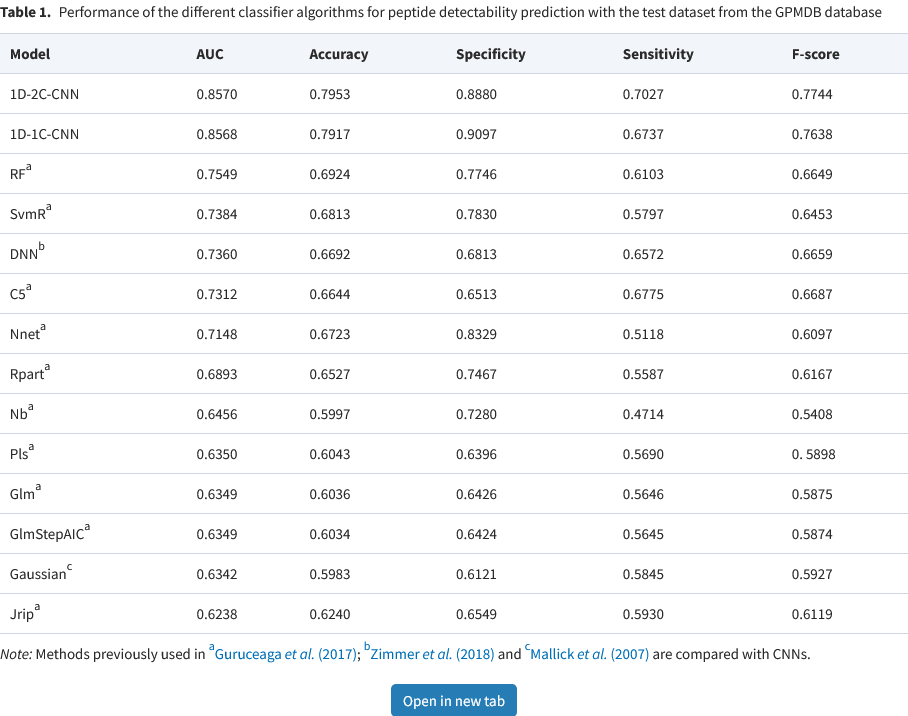

#Hypotheses and Scope of Reproducibility

Hypotheses, where performance is evaluated across (accuracy, specificity, sensitivity, F1 scores, AUC scores):

1.   Convolutional layers will lead to increased performance over past approaches, including the simpler deep neural networks

2.   With just one dense layer, the model's performance will decrease.

3.   Without the hidden layers before the convolutional layers, the model's performance will decrease.

4.   Increased embedding dimensions will lead to increased performance but slower training time

5.   Decreased embedding dimensions will lead to decreased performance but faster training time

# Methodology


## Installation

In [29]:
# to track execution time if all cells are run from start to end
import time
start_time = time.time()

In [30]:
# import packages
import h5py
import requests
import pandas as pd
import numpy as np
from tensorflow import keras
import torch
from torch import nn
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score

print(time.time() - start_time)

0.3652796745300293


##  Data

### Background



The data in this experiment is sourced from The Global Proteome Machine Database (GPMDB), developed by the Global Proteome Machine Organization for scientists using MS. The GPM is a project that aims "to provide a common platform for testing and validating proteomics results" by supporting protein searches across different bioinformatic search engines: Tandem, P3, and Hunter. The GPMDB provides a minimum set of data needed for tasks such as sequence assignment validation. This data includes sequential data as well as physiochemical data for a sampling of many species. [9][10]

The GPMDB was formed by aggregating many peptide mass spectra obtained from experiments, with the goal of allowing queries for a list of previously observed spectra that best match some sequence. Sequences are observed under different experimental conditions, such as different ion charge states or MS configurations [2].

The method that the authors in the paper used involved a download from a now defunct link (http://peptides.thegpm.org/~/peptides_by_species/), and the GPM website contains many other defunct links as well. The current process to run GPMDB involves using an Apache web server, MySQL installation, and Perl: https://www.thegpm.org/gpmdb/gpmdb_install_win.html.

For the sake of convenience, the authors have provided preprocessed data. They have taken detection frequencies for each peptide in GPMDB, sorted them by number of observations in experiments and properties related to observation frequency, selected nonredundant properties, then split the dataset 75/25 across 100,000 peptides.[4]

In the code below, the files provided by the author are further processed into inputs for the paper's models. Peptide sequence data and detection class are extracted. The peptide sequence data is made of chains of 22 possible amino acids which are each represented by a letter. The length of the amino acids can be up to 81. Thus, the data is converted into vectors of length 81 which contain values 1-22 that represent a mapped amino acid sequence. Batches of 100 are prepared for training and testing. The physiochemical properties are maintained in the data, though they are not used in model training. Each peptide has a class of either 'MObs' (more observed) or 'LObs' (less observed), corresponding to a 1/0 label in this experiment.

### Download

In [31]:
# download data and keras model (original at github link, copy preserved in google drive)

# GPMDB Training Peptides
# !wget 'https://raw.githubusercontent.com/vsegurar/DeepMSPeptide/master/Datasets/GPMDB_training_peptides.rar'
# !unrar x GPMDB_training_peptides.rar
# https://drive.google.com/file/d/1KssvUYyhGWr9dak4dyV4eejfpRk5M475/view?usp=drive_link
!gdown 1KssvUYyhGWr9dak4dyV4eejfpRk5M475

# GPMDB Test Peptides
# !wget 'https://raw.githubusercontent.com/vsegurar/DeepMSPeptide/master/Datasets/GPMDB_test_peptides.txt'
# https://drive.google.com/file/d/1FV_Pq6NNhWT_HsZHCTd_HvReNT0F4eM5/view?usp=drive_link
!gdown 1FV_Pq6NNhWT_HsZHCTd_HvReNT0F4eM5

# keras model
# !wget 'https://raw.githubusercontent.com/vsegurar/DeepMSPeptide/master/DeepMSPeptide/model_2_1D.h5'
# https://drive.google.com/file/d/1e2pyNbHEb2E1AS97w5fxODKF52hsy4w4/view?usp=drive_link
!gdown 1e2pyNbHEb2E1AS97w5fxODKF52hsy4w4


print(time.time() - start_time)

Downloading...
From: https://drive.google.com/uc?id=1KssvUYyhGWr9dak4dyV4eejfpRk5M475
To: /content/GPMDB_training_peptides.txt
100% 45.2M/45.2M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FV_Pq6NNhWT_HsZHCTd_HvReNT0F4eM5
To: /content/GPMDB_test_peptides.txt
100% 15.1M/15.1M [00:00<00:00, 230MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e2pyNbHEb2E1AS97w5fxODKF52hsy4w4
To: /content/model_2_1D.h5
100% 22.8M/22.8M [00:00<00:00, 206MB/s]
9.399239540100098


### Preparation

In [32]:
# create a dataframe out of tab-separated files
def get_df_from_file(file_path):
  data_file = open(file_path)
  file_lines = data_file.readlines()
  data = []
  for line in file_lines:
    data.append(line.strip().split('\t'))
  df = pd.DataFrame(data)
  df.columns = df.iloc[0]
  df = df[1:]
  return df

# convert dataframe to Tensor that encodes amino acids into integer ids
def encode_pep_seqs(df):
  aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
  pep_codes = torch.zeros((len(df), 81), dtype=torch.int32)
  for i in range(1, len(df)+1):
    for j in range(len(df[i])):
      value = df[i][j]
      pep_codes[i-1][j] = int(aa_dict[value])
  return pep_codes

# convert dataframe to Tensor that converts the class of amino acids to a binary label (0 or 1)
def encode_class_labels(df):
  classes = []
  for item in df:
    if item == 'MObs':
      classes.append(1)
    else:
      classes.append(0)
  return torch.Tensor(classes)

In [33]:
# Peptide Dataset
class PeptideDataset(torch.utils.data.Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.targets[idx]

In [34]:
# training data with all features in dataset
raw_train_df = get_df_from_file('GPMDB_training_peptides.txt')

# training data with sequence and label extracted
train_df = raw_train_df[['Peptide_seq', 'Class']]

# test data with all features in dataset
raw_test_df = get_df_from_file('GPMDB_test_peptides.txt')

# test data with sequence and label extracted
test_df = raw_test_df[['Peptide_seq', 'Class']]

print(time.time() - start_time)

15.869462013244629


In [35]:
# encoded training peptide sequences
train_peps_x = encode_pep_seqs(train_df['Peptide_seq'])

# encoded training peptide detectability class labels
train_peps_y = encode_class_labels(train_df['Class'])

# encoded test peptide sequences
test_peps_x = encode_pep_seqs(test_df['Peptide_seq'])
test_peps_y = encode_class_labels(test_df['Class'])

print(time.time() - start_time)

34.76824474334717


In [36]:
# prepare training dataloader
peptide_train_dataset = PeptideDataset(train_peps_x, train_peps_y)
peptide_train_dataloader = torch.utils.data.DataLoader(peptide_train_dataset, batch_size=100, shuffle=True)

print(time.time() - start_time)

34.78163242340088


In [37]:
# prepare test dataloader
peptide_test_dataset = PeptideDataset(test_peps_x, test_peps_y)
peptide_test_dataloader = torch.utils.data.DataLoader(peptide_test_dataset, batch_size=100, shuffle=True)

print(time.time() - start_time)

34.79464769363403


### Analysis

#### Dataset Features

While the dataset provides many properties related to the peptide sequence, we are exclusively interested in the sequence data and its associated binary class of detectability. The training dataset consists of 74998 sequences and labels, and the test dataset consists of 24997 sequences and labels. They are split roughly 50/50, with the training set containing 37500 sequences with the class LObs (0) and 37498 with the class MObs (1), and the test set containing 12500 sequences with the class LObs and 12497 with the class MObs.

The frequency of each amino acid is plotted below. When sorted least to greatest, we see a roughly linear pattern of growth emerge. Although it's difficult to conclude much based on this alone, this distribution of data suggests that amino acids don't all have an equal chance of occurring in a sequence, meaning that the presence of certain amino acids can be a good indicator of certain patterns.

In [38]:
# all dataset features in training set
print(raw_train_df.columns)

print('\n\n')

# describing relevant features in training set
print(train_df.describe())
print(train_df['Class'].value_counts())

print('\n\n')

# describing relevant features in testing set
print(test_df.describe())
print(test_df['Class'].value_counts())

Index(['Peptide_seq', 'BUNA790103', 'CHAM820102', 'CHOP780207', 'FASG760102',
       'FASG760103', 'GEIM800103', 'KARP850103', 'KHAG800101', 'LEWP710101',
       'MAXF760103', 'OOBM850103', 'PALJ810108', 'PALJ810111', 'PRAM820101',
       'QIAN880102', 'QIAN880103', 'QIAN880129', 'QIAN880130', 'QIAN880139',
       'RACS820104', 'RACS820113', 'RICJ880112', 'RICJ880116', 'ROBB760109',
       'ROSM880103', 'SNEP660101', 'SUEM840102', 'TANS770106', 'VASM830102',
       'VASM830103', 'WERD780103', 'AURR980102', 'KOEP990102', 'AVBF000109',
       'MITS020101', 'ROBB760110', 'KRIW790101', 'FAUJ880113', 'FAUJ880102',
       'GUYH850105', 'ROBB760112', 'JOND750102', 'ZIMJ680102', 'ZIMJ680104',
       'RICJ880106', 'GEIM800109', 'RACS820105', 'QIAN880115', 'ZASB820101',
       'YUTK870104', 'AVBF000106', 'Aliphatic', 'Basic', 'Acidic',
       'pep_length', 'pep_PI', 'pep_PMW', 'Class'],
      dtype='object', name=0)



0           Peptide_seq  Class
count             74998  74998
unique         

#### Dataset Values

In [39]:
# return counts of amino acids
def count_aa(dataset, limit=None):
  aa_counts = dict()
  iterations = 0
  for i in range(len(dataset)):
    inputs, labels = dataset[i]
    for j in range(len(inputs)):
      aa = inputs[j].item()
      if aa == 0:
        break
      elif aa in aa_counts:
        aa_counts[aa] += 1
      else:
        aa_counts[aa] = 0
    iterations += 1
    if limit and iterations >= limit:
      break

  return aa_counts

min 20 9575 max 11 108519 total 1195968
40.55991554260254


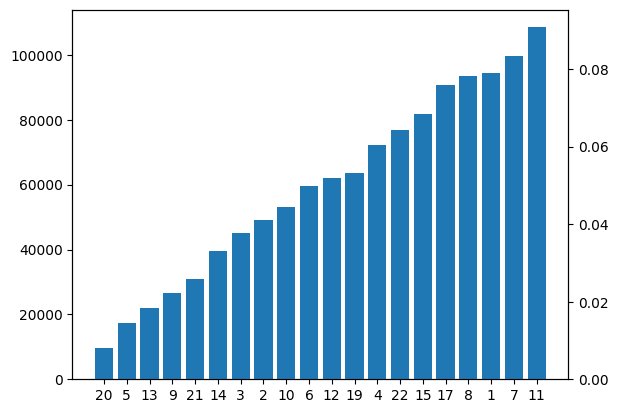

In [40]:
# plotting the animo acid frequency, both raw counts and percent of total animo acids
aa_1_counts = sorted(count_aa(peptide_train_dataset).items(), key=lambda x:x[1])
aa_counts = aa_1_counts

aa_x, aa_y, aa_y_percent= [], [], []
for aa, count in aa_counts:
  aa_x.append(str(aa))
  aa_y.append(count)

total = sum(aa_y)
for y in aa_y:
  aa_y_percent.append(y/total)

min_aa_y = min(aa_y)
min_aa_x = aa_x[aa_y.index(min_aa_y)]
max_aa_y = max(aa_y)
max_aa_x = aa_x[aa_y.index(max_aa_y)]
print('min', min_aa_x, min_aa_y, 'max', max_aa_x, max_aa_y, 'total', total)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(aa_x, aa_y)
ax2.bar(aa_x, aa_y_percent)

print(time.time() - start_time)

##   Model

### Background

The architecture of the paper's proposed ideal model is shown below, broken down by layer and significant parameters based on the original model's terminology. The model is provided in keras. This project reimplements the model and ablation experiments in PyTorch.

#### Model Architecture

- Layer 1: Embedding. (23, 50), initializer=RandomUniform, minval=-0.05, maxval=0.05

- Layer 2: Dropout. rate=0.2

- Layer 3: 1D Convolutional Layer. (50, 128). filters=128, kernel_size=3, strides=1, padding=same, dilation_rate=1, activation=relu kernel_init=GlorotUniform

- Layer 4: 1D Convolutional Layer. (128, 64). filters=64, kernel_size=2, strides=1, padding=valid, dilation_rate=1, activation=relu, kernel_init=GlorotUniform

- Layer 5: Global Max Pooling.

- Layer 6: Dense Linear layer. (64, 64). units=64, kernel_init=GlorotUniform

- Layer 7: Dropout. rate=0.2

- Layer 8: ReLU activation.

- Layer 9: Dense Linear layer. units=1, kernel_init=GlorotUniform(64, 1)

- Layer 10: Sigmoid activation.

#### Training Objectives

The loss function is binary cross entropy loss. The Adam optimizer is used with the default learning rate of 0.001.

### Keras

This is the model provided by the authors of the paper.

In [41]:
# this code loads the original keras model provided by the authors of the paper
f = h5py.File('model_2_1D.h5', 'r')
attrs = json.loads(f.attrs.get('model_config'))
keras_model_2_1D = keras.models.load_model('model_2_1D.h5')

In [42]:
def recursive_print(x, end='\t'):
  if type(x) == dict:
    for k, v in x.items():
      print(end, k)
      recursive_print(v, end+'\t')
  else:
    print(end, x)

# print model architecture
for item in attrs['config']['layers']:
  recursive_print(item)

	 class_name
		 Embedding
	 config
		 name
			 embedding_1
		 trainable
			 True
		 batch_input_shape
			 [None, 81]
		 dtype
			 float32
		 input_dim
			 23
		 output_dim
			 50
		 embeddings_initializer
			 class_name
				 RandomUniform
			 config
				 minval
					 -0.05
				 maxval
					 0.05
				 seed
					 None
				 dtype
					 float32
		 embeddings_regularizer
			 None
		 activity_regularizer
			 None
		 embeddings_constraint
			 None
		 mask_zero
			 False
		 input_length
			 81
	 class_name
		 Dropout
	 config
		 name
			 dropout_2
		 trainable
			 True
		 dtype
			 float32
		 rate
			 0.2
		 noise_shape
			 None
		 seed
			 None
	 class_name
		 Conv1D
	 config
		 name
			 conv1d_1
		 trainable
			 True
		 dtype
			 float32
		 filters
			 128
		 kernel_size
			 [3]
		 strides
			 [1]
		 padding
			 same
		 data_format
			 channels_last
		 dilation_rate
			 [1]
		 activation
			 relu
		 use_bias
			 True
		 kernel_initializer
			 class_name
				 GlorotUniform
			 config
				 see

### Pytorch

In [43]:
class DeepMSPeptide(nn.Module):
  def __init__(self,num_embeddings=23, embedding_dim=50, embedding_uniform_lower=-0.05, embedding_uniform_upper=0.05,
               dropout_1=0.2, dropout_1_enabled=True,
               conv1d_1_in=50, conv1d_1_out=128, conv1d_1_kernel_size=3, conv1d_1_stride=1, conv1d_1_padding='same', conv1d_1_dilation=1,
               conv1d_2_in=128, conv1d_2_out=64, conv1d_2_kernel_size=2, conv1d_2_stride=1, conv1d_2_padding='valid', conv1d_2_dilation=1,
               global_max_pooling_p=1,
               dense_1_in=64, dense_1_out=64, dense_1_enabled=True,
               dropout_2=0.2, dropout_2_enabled=True,
               activation_1_enabled=True,
               dense_2_in=64, dense_2_out=1, dense_2_enabled=True,
               activation_2_enabled=True):
    super(DeepMSPeptide, self).__init__()

    self.embedding_layer=nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    self.embedding_layer.weight.data.uniform_(embedding_uniform_lower, embedding_uniform_upper)

    self.dropout1 = nn.Dropout(dropout_1)
    self.dropout_1_enabled = dropout_1_enabled

    self.conv1d_1 = nn.Conv1d(embedding_dim, conv1d_1_out, kernel_size=conv1d_1_kernel_size, stride=conv1d_1_stride, padding=conv1d_1_padding, dtype=torch.float, dilation=conv1d_1_dilation, bias=True)
    nn.init.xavier_uniform_(self.conv1d_1.weight)
    self.conv1d_1_relu = nn.ReLU()

    self.conv1d_2 = nn.Conv1d(conv1d_2_in, conv1d_2_out, kernel_size=conv1d_2_kernel_size, stride=conv1d_2_stride, padding=conv1d_2_padding, dtype=torch.float, dilation=conv1d_2_dilation, bias=True)
    nn.init.xavier_uniform_(self.conv1d_2.weight)
    self.conv1d_2_relu = nn.ReLU()

    self.global_max_pooling = nn.AdaptiveMaxPool1d(global_max_pooling_p)

    self.linear1 = nn.Linear(dense_1_in, dense_1_out)
    nn.init.xavier_uniform_(self.linear1.weight)
    self.dense_1_enabled = dense_1_enabled
    #self.sigmoid1 = nn.Sigmoid()

    self.dropout2 = nn.Dropout(dropout_2)
    self.dropout_2_enabled = dropout_2_enabled

    self.activation1 = nn.ReLU()

    self.linear2 = nn.Linear(dense_2_in, dense_2_out)
    nn.init.xavier_uniform_(self.linear2.weight)
    self.dense_2_enabled = dense_2_enabled

    self.activation2 = nn.Sigmoid()

  def verbose_print(self, name, x):
    print(name, x.shape, '\n', x)

  def forward(self, x, verbose=False):
    if verbose: self.verbose_print('x', x)

    x = self.embedding_layer(x)
    if verbose: self.verbose_print('embeddings', x)

    if self.dropout_1_enabled:
      x = self.dropout1(x)
      if verbose: self.verbose_print('dropout', x)

    x = torch.permute(x, (0, 2, 1))
    if verbose: self.verbose_print('permute', x)

    x = self.conv1d_1(x)
    if verbose: self.verbose_print('conv1d', x)

    x = self.conv1d_1_relu(x)
    if verbose: self.verbose_print('conv1d relu', x)

    x = self.conv1d_2(x)
    if verbose: self.verbose_print('conv1d2', x)

    x = self.conv1d_2_relu(x)
    if verbose: self.verbose_print('conv1d2 relu', x)

    x = self.global_max_pooling(x)
    if verbose: self.verbose_print('max pooled', x)

    x = x.view(x.size(0), -1)
    if verbose: self.verbose_print('x view', x)

    if self.dense_1_enabled:
      x = self.linear1(x)
      if verbose: self.verbose_print('dense linear1', x)

    if self.dropout_2_enabled:
      x = self.dropout2(x)
      if verbose: self.verbose_print('dropout2', x)

    x = self.activation1(x)
    if verbose: self.verbose_print('activ1', x)

    if self.dense_2_enabled:
      x = self.linear2(x)
      if verbose: self.verbose_print('dense linear2', x)

    return self.activation2(x)

# Results

There are two parts to the experiment here:

1. reproducibility: the original model proposed by the authors is replicated as closely as possible, using the model architecture described above as well as 200 epochs and a batch size of 100. The performance of this model is:

  - Accuracy: 0.7925751090130816
  - Specificity: 0.71632
  - Sensitivity: 0.868848523645675
  - F1-score: 0.8072562358276645
  - AUC: 0.7925842618228376

  The authors report a result of:

  - Accuracy: 0.7953
  - Specificity: 0.8880
  - Sensitivity: 0.7027
  - F1-score: 0.7744
  - AUC: 0.8570

  The accuracy between the trained model and the reported model are extremely close. The specificity and sensitivity values are almost flipped for the models, with the trained model having higher sensitivity but the reported model having higher specificity. The F1-score is slightly higher in the trained model. The AUC is noticeably lower in the trained model than the reported model.

2. ablation comparisons: the additional model experiments involve training the following at 50 epochs:
  - regular model:
    - Acc: 0.7952954354522542
    - Spec: 0.73544
    - Sens: 0.8551652396575178
    - F1-score: 0.8068400588879243
    - AUC: 0.7953026198287588
  - removing the dropout layers:
    - Acc: 0.7723726847221667
    - Spec: 0.75224
    - Sens: 0.7925102024485876
    - F1-score: 0.7768452427641384
    - AUC: 0.7723751012242939
  - removing one of the dense layers
    - Acc: 0.5000600072008641
    - Spec: 1.0
    - Sens: 0.0
    - F1-score: 0.0
    - AUC: 0.5
  - reducing the embedding dimensions from 50 to 25
    - Acc: 0.7972156658799056
    - Spec: 0.69
    - Sens: 0.9044570696967272
    - F1-score: 0.8168383017163505
    - AUC: 0.7972285348483635
  - increasing the embedding dimensions from 50 to 75
    - Acc: 0.7957754930591671
    - Spec: 0.68856
    - Sens: 0.9030167240137633
    - F1-Score: 0.8155374887082204
    - AUC: 0.7957883620068816

  The regular model at 50 epochs performs similarly enough to the regular model at 200 epochs to be useful as a comparison.

  Removing the dropout layers causes the accuracy to slightly decrease, specificity to slight increase in tradeoff with a noticeable decrease in sensitivity, and a slight decrease in F-score and AUC. Overall, this model appears to perform worse without the dropout layers to improve generalization, especially as there are fewer false positives without the dropout layers but many more false negatives.

  Removing one of the dense layers causes the model to fail to learn from the data at all. Every value is labeled positively, and since the class is split evenly between positive and negative assignments, this leads to an accuracy of 0.5, a specificity of 1.0, sensitivity of 0, f1-score of 0, and AUC of 0.5. This model is practically useless.

  Reducing the embedding dimensions causes the accuracy to marginally increase, though this is small enough to potentially be the result of stochastic influences. The specificity declined while the sensitivity increased. The F1-score and AUc scores slightly increase. This model performs closely to the original model, with the biggest difference being the specificity-sensitivity tradeoff.

  Increasing the embedding dimensions causes the accuracy to slightly increase, more than reducing it did. The specificity and sensitivity are slightly worse than in the reduced embedding dimensions model, while the F1-score and AUC are slightly worse. This model also performs closely to the original model.

The losses associated with each experiment are graphed. While the loss is volatile, there's a general decrease in the losses of most models except for model 2 without the dense layer which has a highly irregular shape reflecting an inability for the model to learn the data.

Overall, the experiment is successfully reproduced. We can concluded that the dropout layers are important to improve generalization based on the significant drop in sensitivity. Without the dense layers, the model only predicts 1 and doesn't learn from the data. Reducing and increasing embedding dimensions don't seem to make a significant difference in the model performance, at least at the dimensions tested.

## Preparation

In [44]:
def generate_models():
  dmp = DeepMSPeptide()
  dmp_no_dropout = DeepMSPeptide(dropout_1_enabled=False, dropout_2_enabled=False)
  dmp_no_dense = DeepMSPeptide(dense_1_out=1, activation_1_enabled=False, dropout_2_enabled=False, dense_2_enabled=False)
  dmp_reduced_embeds = DeepMSPeptide(embedding_dim=25)
  dmp_increased_embeds = DeepMSPeptide(embedding_dim=75)
  return dmp, dmp_no_dropout, dmp_no_dense, dmp_reduced_embeds, dmp_increased_embeds

print(time.time() - start_time)

41.34456539154053


In [45]:
# model_0_50 https://drive.google.com/file/d/1rESo-FCbzQ-GHjnCll6nW8gndbDbR9Iz/view?usp=drive_link
!gdown 1rESo-FCbzQ-GHjnCll6nW8gndbDbR9Iz

# model_1_50 https://drive.google.com/file/d/1QHp83LFgn1njmy1aKk6nsaSIIgJQbhFD/view?usp=drive_link
!gdown 1QHp83LFgn1njmy1aKk6nsaSIIgJQbhFD

# model_2_50 https://drive.google.com/file/d/1lb1eS_sSA47JCYbLpx4wiEs8YPsXTSbz/view?usp=drive_link
!gdown 1lb1eS_sSA47JCYbLpx4wiEs8YPsXTSbz

# model_3_50 https://drive.google.com/file/d/1GHEe6Kgz_b41EOIU2m6mfko1eybRWbVy/view?usp=drive_link
!gdown 1GHEe6Kgz_b41EOIU2m6mfko1eybRWbVy

# model_4_50 https://drive.google.com/file/d/1XKVmt1-MEjoYG08vp5QjSHBpf83_UIS5/view?usp=drive_link
!gdown 1XKVmt1-MEjoYG08vp5QjSHBpf83_UIS5

# model_0_200 https://drive.google.com/file/d/14yT6GN9bXy5P9_gZvbnFkijSdZyJl9tO/view?usp=drive_link
!gdown 14yT6GN9bXy5P9_gZvbnFkijSdZyJl9tO
print(time.time() - start_time)

Downloading...
From: https://drive.google.com/uc?id=1rESo-FCbzQ-GHjnCll6nW8gndbDbR9Iz
To: /content/model_0_50
100% 842k/842k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QHp83LFgn1njmy1aKk6nsaSIIgJQbhFD
To: /content/model_1_50
100% 842k/842k [00:00<00:00, 127MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lb1eS_sSA47JCYbLpx4wiEs8YPsXTSbz
To: /content/model_2_50
100% 791k/791k [00:00<00:00, 89.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GHEe6Kgz_b41EOIU2m6mfko1eybRWbVy
To: /content/model_3_50
100% 720k/720k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XKVmt1-MEjoYG08vp5QjSHBpf83_UIS5
To: /content/model_4_50
100% 964k/964k [00:00<00:00, 86.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=14yT6GN9bXy5P9_gZvbnFkijSdZyJl9tO
To: /content/model_0_200
100% 1.85M/1.85M [00:00<00:00, 21.9MB/s]
52.84511971473694


## Training

In [46]:
# one training cycle across a number of epochs and batches
def dmp_train(d, epochs=200, input_batches_limit=None):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(d.parameters())
  losses = []
  for epoch in range(epochs):
    epoch_losses = []
    d.train()
    i = 0
    for inputs, labels in peptide_train_dataloader:
      optimizer.zero_grad()
      yhat = d(inputs).squeeze()
      y = labels.float()
      loss = criterion(yhat, y)
      loss.backward()
      optimizer.step()
      if input_batches_limit and i >= input_batches_limit:
        break
      i += 1
      losses.append(loss.item())
      epoch_losses.append(loss.item())
      if len(losses) >= 5 and all(round(el, 5) == round(losses[-1],5) for el in losses[-5:]):
        return losses, optimizer
  return losses, optimizer

# show losses after training
def plot_losses(losses, skip=1):
  skip_losses = []
  avg_loss = 0
  for i in range(len(losses)):
    avg_loss += losses[i]
    if i%skip == 0:
      skip_losses.append(avg_loss/skip)
      avg_loss = 0
  plt.plot(skip_losses)
  plt.show()

# report evaluation metrics for a model: accuracy, specificity, sensitivity, F1 scores, AUC scores.
def dmp_eval(d, batch_iteration_limit=None):
  y_preds = []
  y_true = []
  d.eval()
  j = 0
  limit = 0
  for inputs, labels in peptide_test_dataloader:
    outputs = d(inputs)
    preds = (outputs.squeeze() > 0.5).int()
    y_preds.extend(preds)
    y_true.extend(labels)
    limit += 1
    if batch_iteration_limit and limit >= batch_iteration_limit:
      break

  acc = accuracy_score(y_true, y_preds)
  tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
  spec = tn / (tn+fp)
  sens = tp / (tp+fn)
  f1 = f1_score(y_true, y_preds)
  auc = roc_auc_score(y_true, y_preds)

  return acc, spec, sens, f1, auc

In [47]:
def train_models(dmp_models, epochs=1):
  for i, model in enumerate(dmp_models):
    losses, optimizer = dmp_train(model, epochs=epochs, input_batches_limit=None)
    plot_losses(losses)
    acc, spec, sens, f1, auc = dmp_eval(model)
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses
    }, f'model_{i}_{epochs}')
    print(acc, spec, sens, f1, auc)
    print(time.time() - start_time)

In [48]:
# this code demonstrates the training process on a limited basis of 3 epochs and 30 batches and compares the results against an untrained model.
print(time.time()-start_time)
untrained_model = DeepMSPeptide()
print('untrained', dmp_eval(untrained_model, batch_iteration_limit=30))

print(time.time() - start_time)
test_model = DeepMSPeptide()
dmp_train(test_model, epochs=3, input_batches_limit=30)
print('trained', dmp_eval(test_model, batch_iteration_limit=10))
print(time.time() - start_time)

52.98959231376648
untrained (0.5026666666666667, 0.0, 1.0, 0.6690328305235137, 0.5)
54.2746205329895
trained (0.672, 0.6395833333333333, 0.7019230769230769, 0.6899810964083176, 0.6707532051282052)
60.60455513000488


In [49]:
# this code was used to replicate the original experiment's ideal model as exactly as possible, including 200 epochs
# train_models([DeepMSPeptide()], epochs=200)

In [50]:
# this code was used to train each of the 5 models for 50 epochs each
# train_models(generate_models(), epochs=50)

## Model reproducibility

In [51]:
# this loads the ideal model proposed from the paper, which ran for 200 epochs
model_0_200 = DeepMSPeptide()
model_0_200.load_state_dict(torch.load('model_0_200')['model_state_dict'])

<All keys matched successfully>

In [52]:
# this runs the ideal model through a batch of data from the test data for demonstration purposes
for inputs, labels in peptide_test_dataloader:
  outputs = model_0_200(inputs)
  print([a.item() for a in list(outputs)])
  print([a.item() for a in list(labels)])
  break

print(time.time() - start_time)
# this runs the ideal model through a series of evaluation metrics: accuracy, sensitivity, specificity, f1, auc score
print(dmp_eval(model_0_200))
print(time.time() - start_time)

[0.012270818464457989, 0.9390526413917542, 0.9082196354866028, 3.4036488614219707e-06, 4.488154559112445e-08, 7.014196778953874e-09, 0.027938421815633774, 0.13803289830684662, 0.05269446596503258, 0.6955527663230896, 1.0202267731074244e-05, 6.963385203562211e-06, 0.028207527473568916, 0.08824819326400757, 0.8875367641448975, 0.4649491012096405, 0.584565281867981, 0.3424692153930664, 3.8088483051978983e-06, 0.005255559924989939, 0.7470672726631165, 0.34141236543655396, 0.8326224684715271, 0.46715047955513, 4.157233224333368e-09, 0.8268917798995972, 0.003415684914216399, 0.7078913450241089, 0.958041787147522, 0.8157404065132141, 0.7608194351196289, 1.124307980049366e-09, 1.8957059880198024e-11, 0.909686803817749, 0.9342505931854248, 3.879787527694134e-06, 0.9840917587280273, 0.92922043800354, 0.00012411536590661854, 0.022651996463537216, 0.9368428587913513, 0.7583230137825012, 0.9788793921470642, 0.7570620179176331, 3.516350989229977e-05, 0.18624378740787506, 0.9558791518211365, 0.906729

## Model comparison

In [53]:
# this code loads the ideal model and ablation experiment models trained for 50 epochs
models_50 = generate_models()
for i in range(len(models_50)):
  models_50[i].load_state_dict(torch.load(f'model_{i}_50')['model_state_dict'])

In [54]:
# this code calculates the metrics we are interested in for each model: accuracy, sensitivity, specificity, f1, auc score
accs, specs, senses, f1s, aucs = ([] for i in range(5))
for model in models_50:
  acc, spec, sens, f1, auc = dmp_eval(model, batch_iteration_limit=None)
  accs.append(acc)
  specs.append(spec)
  senses.append(sens)
  f1s.append(f1)
  aucs.append(auc)
  print(acc, spec, sens, f1, auc)
  print(time.time() - start_time)

0.7952954354522542 0.73544 0.8551652396575178 0.8068400588879243 0.7953026198287588
85.09878492355347
0.7723726847221667 0.75224 0.7925102024485876 0.7768452427641384 0.7723751012242939
95.65989375114441
0.5000600072008641 1.0 0.0 0.0 0.5
105.79269194602966
0.7972156658799056 0.69 0.9044570696967272 0.8168383017163505 0.7972285348483635
115.11919736862183
0.7957754930591671 0.68856 0.9030167240137633 0.8155374887082204 0.7957883620068816
128.34526205062866


[[0.7952954354522542, 0.7723726847221667, 0.5000600072008641, 0.7972156658799056, 0.7957754930591671], [0.73544, 0.75224, 1.0, 0.69, 0.68856], [0.8551652396575178, 0.7925102024485876, 0.0, 0.9044570696967272, 0.9030167240137633], [0.8068400588879243, 0.7768452427641384, 0.0, 0.8168383017163505, 0.8155374887082204], [0.7953026198287588, 0.7723751012242939, 0.5, 0.7972285348483635, 0.7957883620068816]]
128.48848176002502


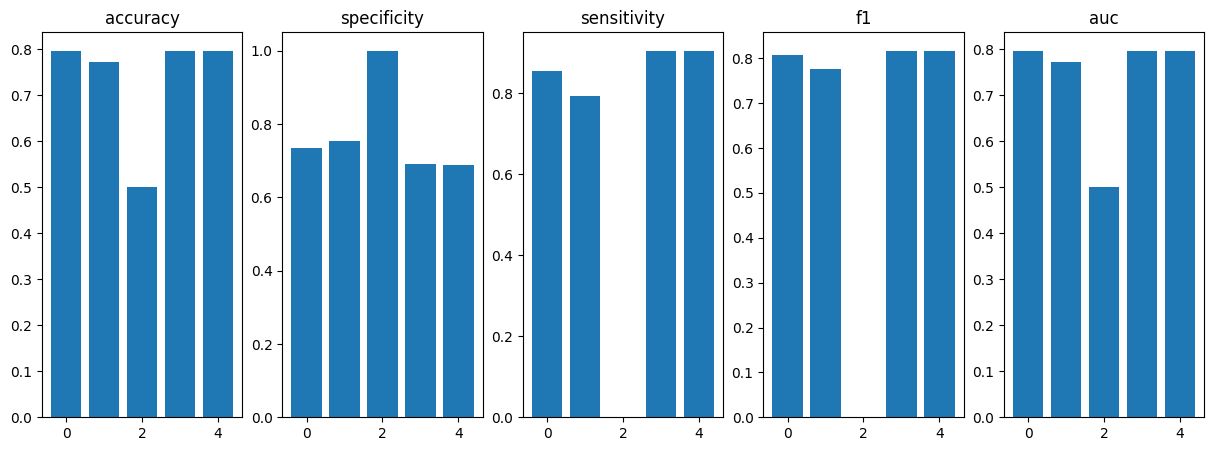

In [55]:
# this code plots the evaluation metrics of each model
metrics = [accs, specs, senses, f1s, aucs]
names = ['accuracy', 'specificity', 'sensitivity', 'f1', 'auc']

fig, axes = plt.subplots(1, len(metrics), figsize=(15,5))

for j, metric in enumerate(metrics):
  axes[j].set_title(names[j])
  axes[j].bar([i for i in range(len(metrics))], metric)

print(metrics)
print(time.time() - start_time)

# Discussion

  The paper is completely reproducible with the code provided. The code is provided in keras alongside the model, even though it is rewritten in PyTorch here for convenience. The result of training this model is consistent with the results reported in the studies: the proposed model, with convolutional layers and training exclusively on peptide sequences, outperforms all previously proposed models as the table at the top of the notebook indicates.

  Replicating the model was easy given the keras code, which held information about each layer and its related parameters. The size of the model and simple structure of the training/test data made repeating experiments very feasible. Trying to find the original source of the data was difficult, as the source (GPMDB) has new complicated installation and setup operations, and the link that was available during the study no longer works. This means data has yet to be retrieved directly from the source to verify that the data was preprocessed successfully.

  Although the model was described in the paper and can be unpacked through analyzing the keras model, a more explicit breakdown of the architecture would've been helpful. Details like a learning rate or type of optimizer used were left out and were left to experimentation. Parameters relevant to the embedding layer, such as dimensions, were also not described in the paper and had to be revealed through analyzing the keras model. Instead of describing the model at a high-level, a complete visual architecture complete with relevant parameters would've been clear and helpful in reproducing the study. Further, an updated instruction set to retrieve and manipulate the data would be helpful. In this paper, the authors refer to an earlier paper they published that actually details the data preprocessing, which is where the broken lnk comes from. Updating the instructions to use the new GPMDB distribution system would help in verifying that the authors used the original data correctly.

  Because training models at 50 epochs requires low resources while serving as a reasonable proxy for 200 epoch models, more experiments can be performed inexpensively. Adding another convolutional layer or hidden dense layer might improve performance. Measuring execution times in the previous ablation experiments might reveal interesting patterns or tradeoffs. Hyperparameters such as embedding dimensions can be further experimented with for optimization of particular metrics. Finally, exploring a model that combines this sequential data processing with the physiochemical properties initially in the dataset might further improve performance.

# References

[1] Al-Amrani S, Al-Jabri Z, Al-Zaabi A, Alshekaili J, Al-Khabori M. Proteomics: Concepts and applications in human medicine. World J Biol Chem. 2021 Sep 27;12(5):57-69. doi: 10.4331/wjbc.v12.i5.57. PMID: 34630910; PMCID: PMC8473418.

[2] Craig R, Cortens JP, Beavis RC. Open source system for analyzing, validating, and storing protein identification data. J Proteome Res. 2004 Nov-Dec;3(6):1234-42. doi: 10.1021/pr049882h. PMID: 15595733.

[3] Guillermo Serrano, Elizabeth Guruceaga, Victor Segura, DeepMSPeptide: peptide detectability prediction using deep learning, Bioinformatics, Volume 36, Issue 4, February 2020, Pages 1279–1280, doi:10.1021/pr049882h.

[4] Guruceaga E, Garin-Muga A, Prieto G, Bejarano B, Marcilla M, Marín-Vicente C, Perez-Riverol Y, Casal JI, Vizcaíno JA, Corrales FJ, Segura V. Enhanced Missing Proteins Detection in NCI60 Cell Lines Using an Integrative Search Engine Approach. J Proteome Res. 2017 Dec 1;16(12):4374-4390. doi: 10.1021/acs.jproteome.7b00388. Epub 2017 Oct 11. PMID: 28960077; PMCID: PMC5737412.

[5] Li YF, Arnold RJ, Tang H, Radivojac P. The importance of peptide detectability for protein identification, quantification, and experiment design in MS/MS proteomics. J Proteome Res. 2010 Dec 3;9(12):6288-97. doi: 10.1021/pr1005586. Epub 2010 Nov 10. PMID: 21067214; PMCID: PMC3006185.

[6] Mallick P, Schirle M, Chen SS, Flory MR, Lee H, Martin D, Ranish J, Raught B, Schmitt R, Werner T, Kuster B, Aebersold R. Computational prediction of proteotypic peptides for quantitative proteomics. Nat Biotechnol. 2007 Jan;25(1):125-31. doi: 10.1038/nbt1275. Epub 2006 Dec 31. PMID: 17195840.

[7] Neagu AN, Jayathirtha M, Baxter E, Donnelly M, Petre BA, Darie CC. Applications of Tandem Mass Spectrometry (MS/MS) in Protein Analysis for Biomedical Research. Molecules. 2022 Apr 8;27(8):2411. doi: 10.3390/molecules27082411. PMID: 35458608; PMCID: PMC9031286.

[8] Zimmer D, Schneider K, Sommer F, Schroda M, Mühlhaus T. Artificial Intelligence Understands Peptide Observability and Assists With Absolute Protein Quantification. Front Plant Sci. 2018 Nov 13;9:1559. doi: 10.3389/fpls.2018.01559. PMID: 30483279; PMCID: PMC6242780.

[9] https://www.thegpm.org/gpm/

[10] https://wiki.thegpm.org/wiki/Main_Page

